Problem statement:
We aim to evaluate the effect of targeted coupon campaigns on product conversion using observational data.

Data:
The dataset consists of 10,000 observations on newsletter subscribers of an online shop.
- conversion: Whether the customer bought the product (binary outcome)
- coupon: Whether the customer used a coupon (binary treatment)
- pre-treatment variables: 
    - X1–X14: Customer features (continuous covariates)
    - membership_level: Customer membership status (categorical, dummy coded)
- post-treatment variables:
    - Z: Post-campaign activity score (numeric)
    - loyality_points: Loyalty points awarded after treatment (numeric)

Comment: 
Technically, all customers were offered a coupon, but only some chose to use it. Therefore, the estimated causal effect pertains to the impact of using a coupon on the conversion rate. As there is no data about customers that did not receive any coupons, this analyis critically relies on the assumption that receiving a coupon does not influence the conversion rather other than through using the coupon (similar to exclusion restriction in iv settings).

References:
Most of this analysis follows standard causal inference literature, for details we refer to, e.g., Causal Inference: What if by Miguel Hernán and James Robin or Causal Inference: The Mixtape by Scott Cunningham.  We use the DoubleML package to implement the main model based on Chernozhukov et al. (2018). For details on DAGs and in particular the backdoor criterion we refer to Judea Pearl's Causality book.

In [28]:
# setup
import numpy as np
import pandas as pd
import scipy.stats as stats
import doubleml as dml
import statsmodels.api as sm
import patsy
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

EDA:

First, some basic checks. The data does not contain missing values and the covariates are already standardized.

In [ ]:
# load data
df = pd.read_csv("data/uplift_data_final.csv", index_col=0)

# missing values? standardized data? balance treatment and control?
print(df.head())
print(df.isnull().sum())
print(df.mean())
print(df.std())

   conversion  coupon        X0        X1        X2        X3        X4  \
0         1.0     1.0 -1.110554 -1.134097  0.128589  0.874238  0.196594   
1         0.0     1.0 -0.515260 -0.150295 -0.076850 -0.204064  0.362197   
2         0.0     0.0  1.160414 -0.345812  0.441647 -1.084716 -1.837146   
3         1.0     0.0 -2.141387 -1.960944 -1.598674 -0.887552 -1.632236   
4         0.0     1.0 -0.609404 -0.682008 -1.672801 -1.692626 -2.211051   

         X5        X6        X7  ...       X11       X12       X13       X14  \
0  2.040795  0.354033 -0.766300  ... -0.314289 -0.412576 -0.912329 -0.089548   
1  0.573354  0.192715  0.372288  ... -1.663128  0.623341  0.296811 -0.327026   
2 -1.207060 -1.399175  0.203727  ...  0.013339 -0.676666 -1.271227  1.215198   
3  0.681700  0.656121  0.350065  ...  0.389388  0.401734 -0.050694  0.278126   
4 -1.417280  0.670815  1.217301  ... -0.809787  0.067887  0.342862  1.054393   

   membership_level_0  membership_level_1  membership_level_2       

For illustration, we compute the true average treatement effect. Note that naive diffenerence of treated vs control without causal considerations would even imply a different sign for the effect. This is not a randomized study, thus, we have to adjust for confounding or imbalance in the groups, e.g. using causal inference approaches.

We highlight the (marginal) correlation between treatment and the covariates. 

In [4]:
# true average treatment effect?  without causal analysis?
print("true average treatment effect:", df['ite'].mean()) 

treated = df[df['coupon'] == 1]
control = df[df['coupon'] == 0]
print("naive difference in conversion rates:", treated['conversion'].mean()- control['conversion'].mean())

# potential confounding? imbalance? correlation with treatment?
covariates = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
              'X11', 'X12', 'X13', 'X14']
for col in covariates:
    print(f"correlation between {col} and coupon:", np.corrcoef(df[col], df['coupon'])[0, 1])

true average treatment effect: 0.03908395919621665
naive difference in conversion rates: -0.020071941191220577
correlation between X0 and coupon: 0.018481828739076077
correlation between X1 and coupon: 0.008034546295127641
correlation between X2 and coupon: 0.02487746175698864
correlation between X3 and coupon: 0.044094632953325226
correlation between X4 and coupon: 0.06008973524142825
correlation between X5 and coupon: 0.11569101545631695
correlation between X6 and coupon: 0.09585159094710013
correlation between X7 and coupon: 0.1498084290646118
correlation between X8 and coupon: 0.20689439487009248
correlation between X9 and coupon: 0.12702288360936814
correlation between X10 and coupon: 0.14751202127925872
correlation between X11 and coupon: 0.10992197370724054
correlation between X12 and coupon: 0.14475091349319172
correlation between X13 and coupon: 0.12338138760930167
correlation between X14 and coupon: 0.06124696264329803


The first step of causal inference is to reason about underlying causal structure. Here, causal discovery is not necessary and we specify a DAG based on domain knowledge (e.g. time constraints pre-/post-treatment) and minimal assumptions (not necessarily minimal causal dag), where missing edges encode hypothesized absences of direct causal effects. We emphasize, specifying such a causal DAG in particular assumes 
- causal sufficiency (no unobserved confounding)
- causal markov condition (independent mechanism, condintional independence implied by d-separation)
- and acyclicity.

Comments:
Adjusting for all pre-treatment covariates satisfies the backdoor criterion, guaranteeing unbiased effect estimation. However, smaller adjustment sets (e.g., a subset of covariates) may improve efficiency if they block all backdoor paths. For example, selecting covariates with strong marginal correlations with treatment could suffice if they block all confounding paths and yield better performance. However, this relies on correctly identifying a minimal sufficient adjustment set (minimal causal dag), which requires additional conditional independence assumptions.

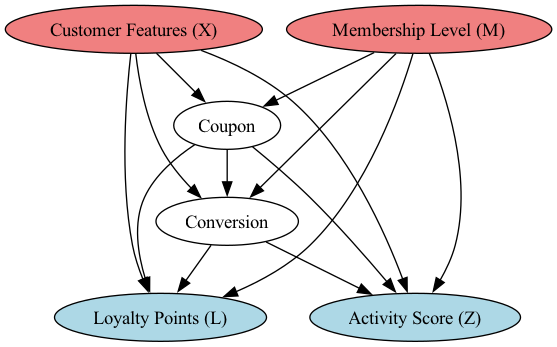

In [29]:
# causal analysis, first step causal graph
from graphviz import Digraph
from IPython.display import Image

dot = Digraph()
dot.attr(rankdir='TB')

with dot.subgraph() as top:
    top.attr(rank='same')
    top.node('X', 'Customer Features (X)', style='filled', fillcolor='lightcoral')
    top.node('M', 'Membership Level (M)', style='filled', fillcolor='lightcoral')

dot.node('C', 'Coupon')
dot.node('Y', 'Conversion')

with dot.subgraph() as bottom:
    bottom.attr(rank='same')
    bottom.node('L', 'Loyalty Points (L)', style='filled', fillcolor='lightblue')
    bottom.node('Z', 'Activity Score (Z)', style='filled', fillcolor='lightblue')

dot.edges([('X', 'C'), ('M', 'C'),
           ('X', 'Y'), ('M', 'Y'),
           ('C', 'Y'),
           ('C', 'L'), ('C', 'Z'),
           ('Y', 'L'), ('Y', 'Z'),
           ('X', 'L'), ('M', 'L'),
           ('X', 'Z'), ('M', 'Z')])

dot.render('dag', format='png', cleanup=True)
Image('dag.png')

Finding a valid adjustment set is the major causal step in the analyis that relates the interventional quantity of interest to observational data. We emphasize, adjusting for colliders d-connects and introduces bias  (Similarly, adjusting for mediators would block a causal path and introduce bias). Thus, we do not adjust for the post-treatment variables.

Comment:
There exist other (graphical) criteria, such as the front-door criterion, that also provide sufficient conditions to identify causal effects from observational data.

In [7]:
# backdoor adjustment set
adjustment_set = covariates + ['membership_level_0', 'membership_level_1', 'membership_level_2']

We are interested in estimating the average treatment effect (ATE) of coupon usage on conversion rate. Formally, this is given as

$$
\text{ATE} = \mathbb{E}[conversion \mid do(coupon=1)] - \mathbb{E}[conversion \mid do(coupon=0)].
$$

Using the backdoor criterion this can be expressed as

$$
\text{ATE} = \mathbb{E}_{X,M} \left[ \mathbb{E}[conversion \mid coupon=1, X, M] - \mathbb{E}[conversion \mid coupon=0, X, M] \right]
$$

The main remaining challenge is to estimate these conditional expectations from data. We will first highlight some important concepts using simple approaches, before employing more sophisticated models to continue with our analysis. The main assumptions for the following approaches are
- positivity (common support, overlap)
- conditional exchangebility (implied by causal sufficiency/no unobserved confounding)
- consistency (implicit in the specficication of the causal dag)

The main idea of ipw is to rebalance the data to mimic a randomized control trial by fitting a treatment model (here logistic regression).
- validity additionally relies on well-specified treatment model


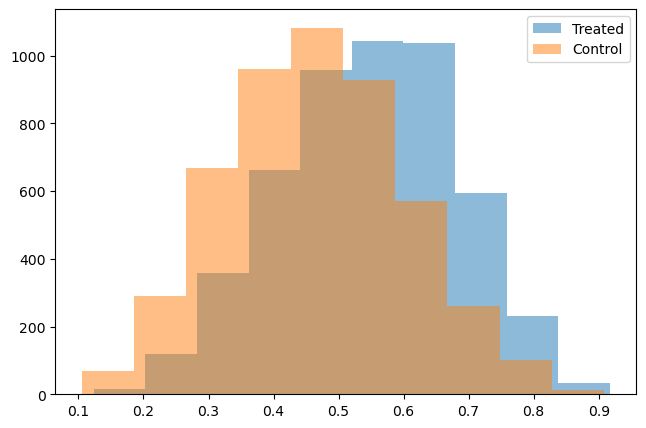

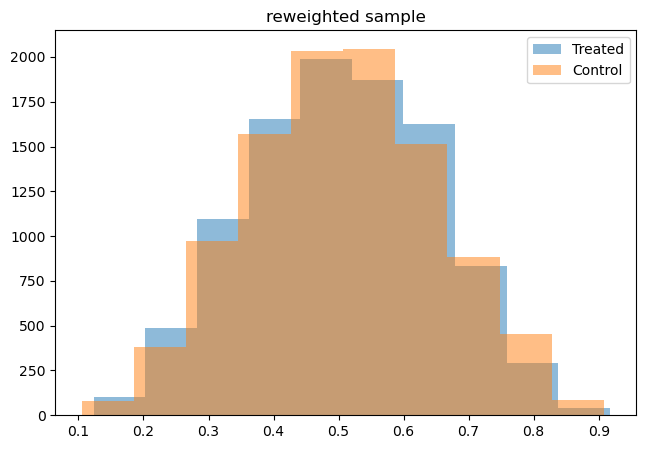

ipw estimated ATE: 0.010870724339120993
true average treatment effect: 0.03908395919621665


In [27]:
# ATE estimation using different methods

# ipw 
prop_model = LogisticRegression(max_iter=1000)
prop_model.fit(df[adjustment_set], df['coupon'])  
propensity = prop_model.predict_proba(df[adjustment_set])[:, 1]

plt.hist(propensity[df['coupon']==1], alpha=0.5, label='Treated')
plt.hist(propensity[df['coupon']==0], alpha=0.5, label='Control')
plt.legend() 
plt.show()


plt.hist(propensity[df['coupon']==1], alpha=0.5, weights=1/propensity[df['coupon']==1], label='Treated')
plt.hist(propensity[df['coupon']==0], alpha=0.5, weights=1/(1-propensity[df['coupon']==0]),label='Control')
plt.title('reweighted sample')
plt.legend() 
plt.show()

ate_iwp = np.mean((df['coupon'] * df['conversion']) / propensity - ((1 - df['coupon']) * df['conversion']) / (1 - propensity))
print("ipw estimated ATE:", ate_iwp)
print("true average treatment effect:", df['ite'].mean()) 

We show that the positivity assumption seems to be satisfied, however, the plot also shows the imbalance in treatment vs control. The second plot shows the idea of ipw of reweighting the data to mimic a rct.

While still underestimating the causal effect, ipw at least identifies the correct sign compared to the naive approach.


Another straightforward approach is to fit directly an outcome model to estimate the conditional expectation (here, again, simple logistic regression).
- validity additionally relies on well-specified outcome model

In [10]:
# logistic regression 
outcome_model = LogisticRegression(max_iter=1000)
outcome_model.fit(df[adjustment_set + ['coupon'] ], df['conversion'])

y_hat_1 = outcome_model.predict_proba(df[adjustment_set + ['coupon'] ].assign(coupon=1))[:, 1]
y_hat_0 = outcome_model.predict_proba(df[adjustment_set + ['coupon'] ].assign(coupon=0))[:, 1]
ate_lr = (y_hat_1-y_hat_0).mean()
print("logistic regression estimated ATE:", ate_lr)
print("true average treatment effect:", df['ite'].mean()) 

logistic regression estimated ATE: 0.011909259494919312
true average treatment effect: 0.03908395919621665


To some extend, the logical next step is to employ doubly robust estimation to combine both worlds. As name suggests, the idea is to fit both a treatment and outcome model in an orthogonal way to ensure validity even if one model is misspecified. The double ml approach extends this idea using data splitting to allow the use of more sophisticated models without worrying about overfitting.

In [ ]:
# doubly robust estimation (here using doubleml)

# logistic regression (simple)
treatment_model = LogisticRegression(max_iter=1000)
outcome_model = LogisticRegression(max_iter=1000)

dml_data = dml.DoubleMLData(df, y_col='conversion', d_cols='coupon',
                        x_cols=adjustment_set)

dml_irm_lr = dml.DoubleMLIRM(dml_data,
                          ml_g=outcome_model,
                          ml_m=treatment_model,
                          n_folds=5)

dml_irm_lr.fit()
print("double logistic regression estimated ATE:\n", dml_irm_lr.summary)
print("true average treatment effect:", df['ite'].mean()) 

double logistic regression estimated ATE:
             coef  std err        t    P>|t|     2.5 %   97.5 %
coupon  0.011841  0.00953  1.24248  0.21406 -0.006838  0.03052
true average treatment effect: 0.03908395919621665


To highlight the idea, we first employ double robust estimation using logistic regression for both, treatment and outcome model.

In [35]:
# random forest (more involved)
treatment_model = RandomForestClassifier(n_estimators=500)
outcome_model = RandomForestRegressor(n_estimators=500)

dml_irm_rf = dml.DoubleMLIRM(dml_data,
                          ml_g=outcome_model,
                          ml_m=treatment_model,
                          n_folds=5)

dml_irm_rf.fit()
print("double random forest estimated ATE:\n", dml_irm_rf.summary)
print("true average treatment effect:", df['ite'].mean()) 

double random forest estimated ATE:
             coef   std err         t     P>|t|     2.5 %    97.5 %
coupon  0.028855  0.009354  3.084947  0.002036  0.010523  0.047188
true average treatment effect: 0.03908395919621665


Finally, we estimate the average treatment effect using double ml by fitting a random forest to both, treatement and outcome model. As a sanity check, note, that the true average treatment effect is contained in the the 95% confidence interval. For details on other common choices of models and hyperparameter tuning, we refer to the recent CLeaR paper 'Hyperparameter Tuning for Causal Inference with Double Machine Learning: A Simulation Study' by Philipp Bach et. al.

Moreover, we can now use our fitted model to guide the decision on which customers should receive a coupon. First, we compute the aver grouped by membership level (GATE).

In [34]:
# GATE estimation by membership level 
membership_level = df[['membership_level_0', 'membership_level_1', 'membership_level_2']].astype('bool')
gate = dml_irm_rf.gate(groups=membership_level)
print("double random forest estimated GATE:\n", gate)

for level in ['membership_level_0', 'membership_level_1', 'membership_level_2']:
    print(f"true GATE {level}: {df['ite'][df[level] == 1].mean()}")

double random forest estimated GATE:
 ================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
                        coef   std err         t     P>|t|    [0.025    0.975]
membership_level_0  0.045372  0.014976  3.029727  0.002448  0.016020  0.074724
membership_level_1  0.012151  0.014396  0.844035  0.398650 -0.016065  0.040367
membership_level_2  0.010817  0.021094  0.512788  0.608100 -0.030527  0.052161
true GATE membership_level_0: 0.06297299239315964
true GATE membership_level_1: 0.025669719591681534
true GATE membership_level_2: 0.018707844852900623


While there seems to be a positive effect in all groups, targeting customors with membership level zero seems particularly valuable.

Moreoever, we can similarly investigate the effect of specific (continuous) covariates by estimtaing the conditional treatment effeect (CATE). The idea here is to fit a basis expansion (e.g., splines) to the covariate of interest and project the treatment effect onto this basis.

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err         t         P>|t|    [0.025    0.975]
0  0.028391  0.009330  3.043032  2.342078e-03  0.010105  0.046678
1 -0.055564  0.009405 -5.907719  3.468773e-09 -0.073998 -0.037130


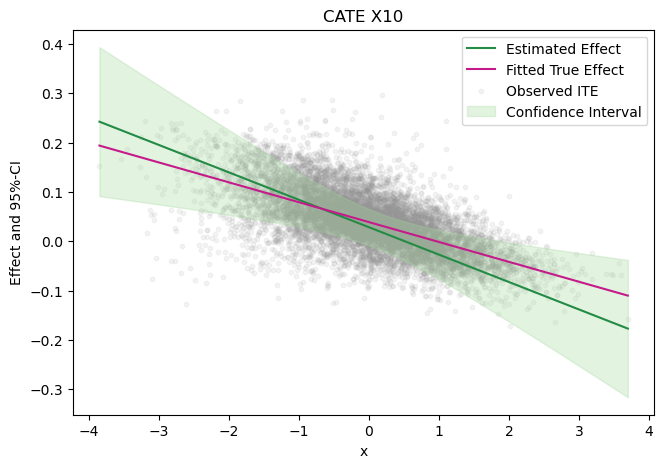

In [37]:
# CATE estimation by X10 (linear projection)
design_matrix=patsy.dmatrix("x", {"x": df['X10']})
spline_basis = pd.DataFrame(design_matrix)
cate = dml_irm_rf.cate(spline_basis)
print(cate)

# visualization 
x_grid = {"x": np.linspace(min(df['X10']), max(df['X10']), 100)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], x_grid)[0])
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=2000)

df_cate['x'] = x_grid['x']
true_fitted_spline = sm.OLS(df['ite'], spline_basis).fit()
df_cate['ite_fitted'] = true_fitted_spline.predict(spline_grid)

fig, ax = plt.subplots()
ax.plot(df_cate['x'],df_cate['effect'], color='#238B45', label='Estimated Effect')
ax.plot(df_cate['x'],df_cate['ite_fitted'], color='#C51B8A', label='Fitted True Effect')
ax.scatter(df['X10'], df['ite'], color='#969696', alpha=0.1, s=10, label='Observed ITE', zorder=1)
ax.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], color='#A1D99B', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE X10')
plt.xlabel('x')
_ =  plt.ylabel('Effect and 95%-CI')

plt.show()

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err         t         P>|t|    [0.025    0.975]
0  0.028170  0.009321  3.022285  2.508742e-03  0.009902  0.046439
1 -0.057558  0.009268 -6.210573  5.279179e-10 -0.075722 -0.039393


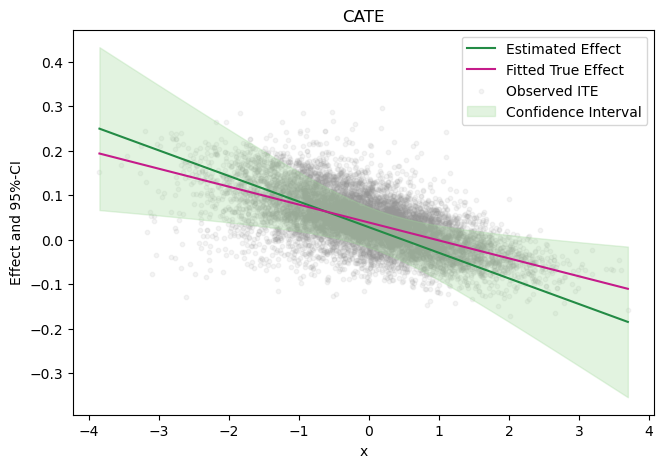

In [ ]:
# CATE estimation by X10 (linear projection)
design_matrix=patsy.dmatrix("x", {"x": df['X10']})
spline_basis = pd.DataFrame(design_matrix)
cate = dml_irm_rf.cate(spline_basis)
print(cate)

# visualization 
x_grid = {"x": np.linspace(min(df['X10']), max(df['X10']), 100)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], x_grid)[0])
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=2000)

df_cate['x'] = x_grid['x']
true_fitted_spline = sm.OLS(df['ite'], spline_basis).fit()
df_cate['ite_fitted'] = true_fitted_spline.predict(spline_grid)

fig, ax = plt.subplots()
ax.plot(df_cate['x'],df_cate['effect'], color='#238B45', label='Estimated Effect')
ax.plot(df_cate['x'],df_cate['ite_fitted'], color='#C51B8A', label='Fitted True Effect')
ax.scatter(df['X10'], df['ite'], color='#969696', alpha=0.1, s=10, label='Observed ITE', zorder=1)
ax.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], color='#A1D99B', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE X10')
plt.xlabel('x')
_ =  plt.ylabel('Effect and 95%-CI')

plt.show()

The covariate X10 seems to have a linear effect on the conversion rate.

================== DoubleMLBLP Object ==================

------------------ Fit summary ------------------
       coef   std err         t         P>|t|    [0.025    0.975]
0  0.047347  0.011593  4.084164  4.423577e-05  0.024626  0.070069
1 -0.043476  0.008802 -4.939460  7.833932e-07 -0.060727 -0.026225
2 -0.019102  0.006135 -3.113364  1.849676e-03 -0.031127 -0.007077


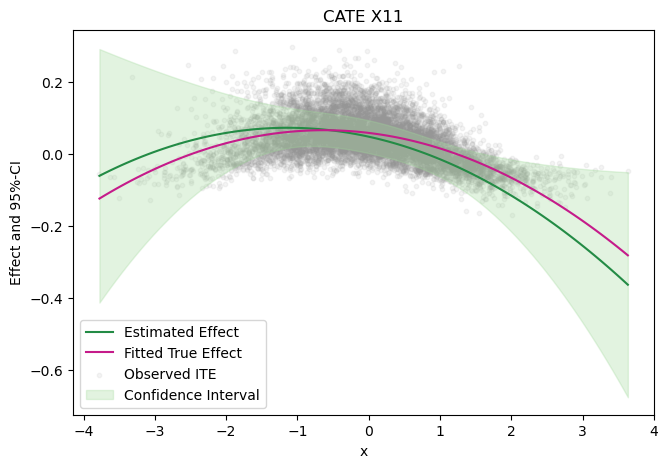

In [36]:
# CATE estimation by X11 (quadratic projection)
design_matrix=patsy.dmatrix("x + I(x**2)", {"x": df['X11']})
spline_basis = pd.DataFrame(design_matrix)
cate = dml_irm_rf.cate(spline_basis)
print(cate)

# visualization 
x_grid = {"x": np.linspace(min(df['X11']), max(df['X11']), 100)}
spline_grid = pd.DataFrame(patsy.build_design_matrices([design_matrix.design_info], x_grid)[0])
df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=2000)

df_cate['x'] = x_grid['x']
true_fitted_spline = sm.OLS(df['ite'], spline_basis).fit()
df_cate['ite_fitted'] = true_fitted_spline.predict(spline_grid)

fig, ax = plt.subplots()
ax.plot(df_cate['x'],df_cate['effect'], color='#238B45', label='Estimated Effect')
ax.plot(df_cate['x'],df_cate['ite_fitted'], color='#C51B8A', label='Fitted True Effect')
ax.scatter(df['X11'], df['ite'], color='#969696', alpha=0.1, s=10, label='Observed ITE', zorder=1)
ax.fill_between(df_cate['x'], df_cate['2.5 %'], df_cate['97.5 %'], color='#A1D99B', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('CATE X11')
plt.xlabel('x')
_ =  plt.ylabel('Effect and 95%-CI')

plt.show()

The covariate X11 seems to have a non-linear effect on the conversion rate.

Further steps could include investigating counterfactuals (would the customer have benn converted even without a coupon?) and evaluating different policies of assigning coupons based on pre-treatment information (e.g., no coupon if X10>2 or X11>1).


Comment:
All methods seem to underestimate the true average treatment effect. To some extent, this is not necessarily suprising and might indicate confounding/selection bias by purchase intent. In fact, highly motivated buyers (who would convert anyway) might be less likely to use a coupon, because they don’t need the discount.  Conversely, people who choose to use the coupon might coorespond to more hesitant, price-sensitive customers.